<a href="https://colab.research.google.com/github/cikufa/Cloud-DCGAN---FID/blob/main/cloudgan_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import PIL
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import keras
from torch.distributions import MultivariateNormal
import pandas as pd
import seaborn as sns 
import scipy
from skimage.transform import resize
from torchvision.models import inception_v3
from PIL import Image 
import torchvision.transforms as transforms
import math

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import random
from numpy.random import randn
from numpy.random import randint

from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, UpSampling2D

#!pip install -Uqq ipdb
#import ipdb
import pdb


Mounted at /content/gdrive


In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape):
    model= Sequential()
	# normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
	# downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
	# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #print(model.summary)
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
	# foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # #sadeghi: upsample to 96*96
    # model.add(Conv2DTranspose(128, (6,6), strides=(3,3), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))

    #sadeghi: upsample to 128*128
    model.add(Conv2DTranspose(128, (8,8), strides=(4,4), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #newwwww
    #sadeghi: upsample to 128*128
    # model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))

    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    print(model.summary)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model



In [ ]:

# create and save a plot of generated images
def save_plot(examples, n=2, path=None):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
 	#imageio.imwrite(filename)
	plt.savefig(path)
	plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch,batch, g_model, d_model, datalist, latent_dim, img_dir, fid, batch_size= 8):
	# prepare real samples
	cropped_images=[] 
	img_num = np.random.randint(0,5500)
	cropped_images, img_num, X_real, y_real = generate_real_samples(cropped_images, img_num, img_dir, datalist, batch_size)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, batch_size)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	#print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	#save plot
	save_plot(x_fake, n=2, path=out_pth+'train_%03d_%03d.png'%(epoch+1 ,batch+1))
	#save the generator model tile file
	if epoch%10==0:
		filename = model_pth + 'generator_%03d_%03d_fid%03d.h5' % (epoch+1, batch+1, fid)
		g_model.save(filename)


In [ ]:
def preprocess(img_dir, IMAGE_SHAPE, crop_idx=[5,7]): #in: each img/ out: 35(or less) cropped, reshaped, adjusted value images 
  cropped_images= []
  with Image.open(img_dir) as img:
    img = img.resize((crop_idx[0]*IMAGE_SHAPE[0] , crop_idx[1]*IMAGE_SHAPE[1]),
                          Image.ANTIALIAS ) #(1400,2100)->(480, 672)=(5*96,7*96)  
    for c in range(crop_idx[1]): #width , col
      for r in range(crop_idx[0]): #heigh , row 
        cropped = img.crop((r*IMAGE_SHAPE[0], c*IMAGE_SHAPE[1], (r+1)*IMAGE_SHAPE[0], (c+1)*IMAGE_SHAPE[1]))
        cropped_blue=cropped.split()[2]
        if (np.count_nonzero(cropped_blue) == IMAGE_SHAPE[0]*IMAGE_SHAPE[1]):
          #cropped.save(os.path.join("dataset/cropped_images_test", f"cropped{i}_{r}_{c}.jpg"))
          cropped =np.array(cropped.getdata()).reshape(cropped.size[1], cropped.size[0], 3)
          cropped = cropped / 127.5 - 1. #-1<training_data<1 , dtype : float64
          cropped_images.append(cropped) 
  #print("cropped len", len(cropped_images))
  # plt.imshow(cropped_images[0])
  # plt.show()
  return cropped_images


def generate_real_samples(cropped_images, img_num, img_dir, datalist, batch_size):  # returns a batch of fake data(img, label)
  #pdb.set_trace()
  while(len(cropped_images) < batch_size):
    img_num= int(np.random.random() * len(datalist))
    cropped_images = cropped_images + preprocess(os.path.join(img_dir, datalist[img_num]), img_shape)
    #img_num = img_num + 1
  real_images = []
  for i in range(batch_size):
    real_images.append(cropped_images.pop())
  real_images = np.array(real_images)
  real_label = np.random.uniform(low= 0.8, high=1.2, size=(batch_size, 1))
  #training_data = np.hstack(training_data, real_label)
  #print("croppeda", len(cropped_images), real_images[0].shape)

  #print("dataloader", len(real_images), real_images[0].shape)
  return cropped_images, img_num, real_images, real_label 
  # training_images= []
  # #tar_width , tar_height= IMAGE_SHAPE[1], IMAGE_SHAPE[0]
  # for i in range(batch_size*batch_num, batch_size*(batch_num+1)):
  #   cropped_images =preprocess(os.path.join(img_dir, datalist[i]))
  #   print("cropped img len", len(cropped_images))
  #   training_images= training_images + cropped_images
    
  # real_label = np.random.uniform(low= 0.8, high=1.2, size=(batch_size, 1))
  # #training_data = np.hst/ack(training_data, real_label)
  # print("dataloader", len(training_images), training_images[0].shape)
  # return training_images, real_label

#_______________________________________________________________________________________________________________________________________________


# generate points in latent space as input for the generator

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, batch_size):   # returns a batch of fake data(img, label)
	# generate points in latent space
  noise= np.random.normal(0,1,(batch_size,latent_dim))	# predict outputs
  fake_img = g_model.predict(noise)
	# create 'fake' class labels (0)
	#y = zeros((n_samples, 1))
  fake_label = np.random.uniform(low= 0.0, high=0.25, size=(batch_size, 1))
  return fake_img, fake_label

In [ ]:

# train the generator and discriminator
def train(img_dir, datalist, g_model, d_model, gan_model, latent_dim, n_epochs, batch_size):

	#200 epoch , each epoch 1927 batch , each batch : 128 img (64 real , 64 fake) 
  #bat_per_epo = int(len(datalist) / batch_size)
  bat_per_epo= 200
  half_batch = int(batch_size / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    print("epoch", i)
    img_num= 0
    cropped_images=[]
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      print(f"bat per epo{j}")
      cropped_images, img_num,  X_real, y_real = generate_real_samples(cropped_images, img_num, img_dir, datalist, half_batch)
     
     # print("x len", len(X_real))
      # print("y len", len(y_real))
      # print("x shape", X_real[0].shape)
      # print("y shape", y_real[0].shape)
     
     # get randomly selected 'real' samples
        # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

      # prepare points in latent space as input for the generator
      #X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      #y_gan = ones((n_batch, 1))
      noise= np.random.normal(0,1,(batch_size,latent_dim))	# predict outputs
      gan_fake_label = np.random.uniform(low= 0.8, high=1.2, size=(batch_size, 1))

      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(noise, gan_fake_label)
      # summarize loss on this batch
  
  # evaluate the model performance, sometimes
      # if (j+1) % 100 == 0:
        #print('>ep: %d,  batch: %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # summarize_performance(i,j , g_model, d_model, datalist, latent_dim, img_dir)
    
    #shuffle:  
    np.random.shuffle(datalist)

  # calc fid after every f epoch 
    if i%freq == 0:
      # print("fid caclc")
      # mu_real1, sigma_real1 = mu_sigma_calc(inception_model, evalbatch, n_samples, 0, None)
      # mu_real2, sigma_real2 = mu_sigma_calc(inception_model, evalbatch, n_samples, 0, None)
      # mu_fake, sigma_fake = mu_sigma_calc(inception_model, evalbatch, n_samples, 1, g_model)
      # fid1 = frechet_distance(mu_real1, mu_fake, sigma_real1, sigma_fake).item()
      # fid2= frechet_distance(mu_real2, mu_fake, sigma_real2, sigma_fake).item()
      # fid= (fid1+fid2)/2
      #print("summerize")
      fid= 1
      summarize_performance(i,j , g_model, d_model, datalist, latent_dim, img_dir,fid , batch_size=8)
      # print(f"fid r1-r2/ epoch {i}", frechet_distance(mu_real1, mu_real2, sigma_real1, sigma_real2).item())
      # print(f"fid r1-f/epoch {i}", frechet_distance(mu_real1, mu_fake, sigma_real1, sigma_fake).item())
      # print(f"fid r2-f/epoch {i}", frechet_distance(mu_real2, mu_fake, sigma_real2, sigma_fake).item())



## **model evaluation **

--- FID ---

In [ ]:
import scipy.stats as stats
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    return torch.norm(mu_x-mu_y)+torch.trace(sigma_x + sigma_y - matrix_sqrt(sigma_x @ sigma_y)*2)
  
# def preprocess(img):
#     img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
#     return img
    
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

def plot_fid(mu_fake , sigma_fake, mu_real, sigma_real):
  #plot
  indices = [2, 4, 5]
  fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
  fake_samples = fake_dist.sample((20,))
  real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
  real_samples = real_dist.sample((20,))

#  df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
  df_fake = pd.DataFrame(fake_samples.numpy()) #shape: (smaple, indices)
  # print("fake unique ", df_fake.index.is_unique)
  # print("faek dupl ", df_fake.index.duplicated())
  #df_fake.loc[~df_fake.index.duplicated(), :]
  df_real = pd.DataFrame(real_samples.numpy())
  # print("real  uni ", df_real.index.is_unique)
  # print("real dupl ", df_real.index.duplicated())
  #df_real.loc[~df_real.index.duplicated(), :]

  #df_fake["is_real"] = "no"
  #df_real["is_real"] = "yes"
  #df = pd.concat([df_fake, df_real])
  # plt.plot(df_fake[0])
  # plt.show()
  # plt.plot(df_real[0])
  # plt.show()
  
  # sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')
  # x = np.linspace(mu_fake - 3*sigma_fake, mu_fake + 3*sigma_fake, 100)
  # plt.plot(x, stats.norm.pdf(x, mu_fake, sigma_fake)) 
  # plt.show()
    
  df_fake["is_real"] = "no"
  df_real["is_real"] = "yes"
  df = pd.concat([df_fake, df_real])
  sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')
  
def mu_sigma_calc(inception_model, evalbatch, n_samples, rf, generator):
  features_list = []
  cur_samples = 0
  imn = int(np.random.random()*(len(datalist)-10))
  cropped=[]
  device= 'cpu'

  with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
  #try:
    #for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
    #for real_samples in tqdm(dataloader):
    for i in range(0, n_samples//evalbatch, evalbatch):
    # while cur_samples < n_samples:
      if (rf == 0): #getin real image features  
        cropped, imn, real_samples, reallbl  = generate_real_samples(cropped_images= cropped,
            img_num=imn, img_dir=data_pth, datalist=datalist, batch_size = evalbatch) #real sample: (evalbatch, 128*128 ,3)
        real_samples= (real_samples + 1)//2  # [-1,1] -> [0,1]
        real_samples= real_samples.reshape((evalbatch,128,128,3)) 
        real_samples= resize(real_samples, (evalbatch, 299, 299))
        real_samples= real_samples.reshape((evalbatch,3,299,299))
        real_samples= torch.tensor(real_samples).float()
        #real_samples = torch.nn.functional.interpolate(real_samples, size=(299, 299), mode='bilinear', align_corners=False) #RECENTLY ADDED
        inception_model = inception_model.float()
        real_features = inception_model(real_samples.to(device)).detach().to('cpu') # (evalbatch,2048)
        features_list.append(real_features)
        
      elif (rf == 1): #getin fake image features  
        noise = np.random.random((evalbatch, latent_dim))
        fake_samples = (generator.predict(noise) + 1)/2  #(evalbatch, 128,128,3)
        #fake_samples= torch.tensor(fake_samples).reshape(evalbatch,3,128,128)
        #fake_samples = torch.nn.functional.interpolate(fake_samples, size=(299, 299), mode='bilinear', align_corners=False)
        fake_samples= resize(fake_samples, (evalbatch, 299, 299)) #(evalbatch, 299,299,3)
        fake_samples= fake_samples.reshape((evalbatch,3,299,299))
        fake_samples= torch.tensor(fake_samples)
        fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
        features_list.append(fake_features)  #(n_samples, 2048)

      #cur_samples += evalbatch
     
  #except:
  # else:
  #   print("Error in loop")
  
  features_all = torch.cat(features_list)
  mu = torch.mean(features_all, 0) #(1,2048)
  sigma = get_covariance(features_all) #(2048,2048)
  # print("mu , sigma", mu.shape, sigma.shape)
  # print("features", len(features_list), features_list[0].shape)
  return mu, sigma

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from torchvision.models import inception_v3

model_pth= 'gdrive/MyDrive/cloud_gan/modeltmp/'
out_pth = 'gdrive/MyDrive/cloud_gan/outtmp/'
test_model_pth = 'gdrive/MyDrive/cloud_gan/model128/generator_090.h5'
data_pth = 'gdrive/MyDrive/cloud_gan/gan_dataset/understanding_cloud_organization/train_images' 
inception_pth= 'gdrive/MyDrive/cloud_gan/inception_v3_google-1a9a5a14.pth'

datalist=[]
for img in tqdm(os.listdir(data_pth)):
  datalist.append(img)
print(len(datalist), datalist[0])

# inception_model = inception_v3(pretrained=False)
# inception_model.load_state_dict(torch.load(inception_pth))
# #inception_model.to(device)
# inception_model = inception_model.eval() # Evaluation mode
# inception_model.fc = torch.nn.Identity()
# # gen.eval()
n=3
evalbatch = n*n
n_samples= 1024 #1024
device= 'cpu'
freq= 10
latent_dim = 100
img_shape=(128,128,3)

  0%|          | 0/5547 [00:00<?, ?it/s]

5547 d148efe.jpg


In [ ]:
checkpoint= None
if checkpoint:
  d_model = keras.models.load(f'gdrive/MyDrive/cloud_gan/checkpoint/disc_{checkpoint}.h5')
  g_model = keras.models.load(f'gdrive/MyDrive/cloud_gan/checkpoint/gen_{checkpoint}.h5')
else:
  d_model = define_discriminator(img_shape)
  #print(d_model.summary())
  g_model = define_generator(latent_dim)
  #print("_________________________________________________________________")
  #print(g_model.summary())
gan_model = define_gan(g_model, d_model)

train(data_pth, datalist, g_model, d_model, gan_model, latent_dim, n_epochs=300, batch_size=8)


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f4417da48d0>>
epoch 0
bat per epo0
bat per epo1
bat per epo2
bat per epo3
bat per epo4
bat per epo5
bat per epo6
bat per epo7
bat per epo8
bat per epo9
bat per epo10
bat per epo11
bat per epo12
bat per epo13
bat per epo14
bat per epo15
bat per epo16
bat per epo17
bat per epo18
bat per epo19
bat per epo20
bat per epo21
bat per epo22
bat per epo23
bat per epo24
bat per epo25
bat per epo26
bat per epo27
bat per epo28
bat per epo29
bat per epo30
bat per epo31
bat per epo32
bat per epo33
bat per epo34
bat per epo35
bat per epo36
bat per epo37
bat per epo38
bat per epo39
bat per epo40
bat per epo41
bat per epo42
bat per epo43
bat per epo44
bat per epo45
bat per epo46
bat per epo47
bat per epo48
bat per epo49
bat per epo50
bat per epo51
bat per epo52
bat per epo53
bat per epo54
bat per epo55
bat per epo56
bat per epo57
bat per epo58
bat per epo59
bat per epo60
bat per epo61
bat per epo62
bat per epo63
bat per epo6

___________________  **SSIM** ______________________________

In [ ]:
import torch  
import torch.nn.functional as F 
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

#______________________________________________________________________________

def create_window(window_size, channel=1):
    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

#________________________________________________________________________________

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),
    pad = window_size // 2
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()
    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

In [ ]:
ssim_batch= 100
cropped_images, img_num, real_ssim1, real_label = generate_real_samples([], 0, data_pth, datalist, ssim_batch)
cropped_images, img_num, real_ssim2, real_label = generate_real_samples([], 3, data_pth, datalist, ssim_batch)
print(real_ssim1.shape)

ssim_rr = ssim(torch.tensor(real_ssim1).float(), torch.tensor(real_ssim2).float(), val_range=255)
print("rr" , ssim_rr)

(100, 256, 256, 3)
rr tensor(0.7904)


tensor(0.7821) tensor(0.7812)


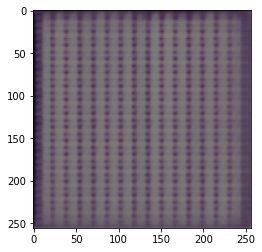

tensor(0.6915) tensor(0.6896)


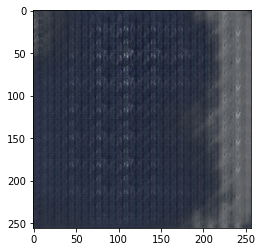

tensor(0.6949) tensor(0.6930)


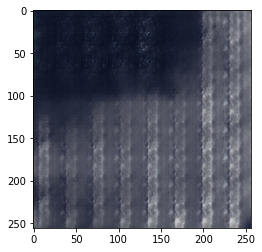

In [ ]:
import keras
import torch 
ssim_batch= 100

noise = np.random.random((ssim_batch,100))

for i in range(3):
  gen = keras.models.load_model('gdrive/MyDrive/cloud_gan/modeltmp/generator_%03d_300.h5'%((1+i*10)))
  fake_ssim = (gen.predict(noise).reshape(ssim_batch,256,256,3) + 1)/2
  ssim_r1f = ssim(torch.tensor(real_ssim1).float(), torch.tensor(fake_ssim).float(), val_range=255)
  ssim_r2f = ssim(torch.tensor(real_ssim2).float(), torch.tensor(fake_ssim).float(), val_range=255)
  print(ssim_r1f, ssim_r2f)
  im= (fake_ssim[0].reshape(128,128,3))
  plt.imshow(im)
  plt.show()

--- MSE ---

In [ ]:
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

def mse(imageA, imageB):
 # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
 mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
 mse_error /= float(imageA.shape[0] * imageA.shape[1])	
 # return the MSE. The lower the error, the more "similar" the two images are.
 return mse_error

noise= np.random.random((1,100))	# predict outputs
gan1 = keras.models.load_model('gdrive/MyDrive/cloud_gan/model128/generator_010.h5')
fake1 = gan1.predict(noise)
fake1 = (fake1[0]+1)/2.0
plt.imshow(fake1)
plt.show()
gan9 = keras.models.load_model('gdrive/MyDrive/cloud_gan/model128/generator_090.h5')
fake9 = gan9.predict(noise)
fake9 = (fake9[0]+1)/2.0
plt.imshow(fake9)
plt.show()
with Image.open('gdrive/MyDrive/cloud_gan/gan_dataset/understanding_cloud_organization/train_images/006bf7c.jpg'
) as real:
  real1 = real.crop((0,0,128,128))
  real2 = real.crop((128,0,256,128))
real1= np.array(real1)
real2= np.array(real2)

print(ssim(real1 , real2, multichannel=True))
print(ssim(real1 , fake1, multichannel=True))
print(ssim(real1 , fake9, multichannel=True))
print(mse(real1 , real2))
print(mse(real1 , fake1))
print(mse(real1 , fake9))


In [ ]:
# ************************************************************ TEST ********************************************************************************
import numpy as np 
import os 
print(os.getcwd())
noise= np.random.normal(0,1,(8,100))	# predict outputs
imgs = g_model.predict(noise)
import matplotlib.pyplot as plt
#i=plt.imread(imgs[0])
plt.imshow(imgs[3])
#plt.show()
plt.savefig("test.png")
g_model.save("gdrive/MyDrive/cloud_gan/generated128/good96model")

# a= np.array([[1,2,3],[4,5,6]]) #(2,3)
# b= np.array([[1,2,3],[4,5,6]]) *2 #(2,3)
# c= np.array([[1,2,3],[4,5,6]])*3 #(2,3)
# one= []
# one.append(a)
# one.append(b)
# one.append(c) #(3,(2,3))
# p=[]
# for i in range(2):
#   p.append(one.pop())
# p=np.array(p)
# print(p.shape)
#print(len(p), p[0].shape)
# two = one
# three = []; three.append(one); three.append(two)
# print(len(one))
# print(one[0].shape)
# print(len(three))
# print(three[0][0].shape)
# four = one+ two
# print("________________________________")
# print(len(four))
# print(four[0].shape)


/content


NameError: ignored

In [ ]:
evalbatch= 8
cr_, imn_, img_, lbl_  = generate_real_samples(cropped_images=[],
          img_num=0, img_dir=data_pth, datalist=datalist, batch = 1)

print(img_.shape)
gen = keras.models.load_model(f'gdrive/MyDrive/cloud_gan/modeltmp/generator_051_300.h5')
im = generate_fake_samples(g_model, latent_dim, 1)
print(im.shape)


# mu_real1, sigma_real1 = mu_sigma_calc(inception_model, evalbatch, n_samples, 0, None)
# mu_real2, sigma_real2 = mu_sigma_calc(inception_model, evalbatch, n_samples, 0, None)
# print("frechet distance real1-real2:", frechet_distance(mu_real1, mu_real2, sigma_real1, sigma_real2).item())
# save_plot(img_,n=2, path = out_pth + 'test_real.png')

# with torch.no_grad():
#   for i , g in enumerate(os.listdir('gdrive/MyDrive/cloud_gan/modeltmp')):
#     gen = keras.models.load_model(f'gdrive/MyDrive/cloud_gan/modeltmp/{g}')
#     #frechet
#     mu_fake, sigma_fake = mu_sigma_calc(inception_model, evalbatch, n_samples, 1, gen)
#     fid = frechet_distance(mu_fake, mu_real1, sigma_fake, sigma_real1).item()
#     print(f"frechet distance real1-fake{i}:",fid)
#     #monitor output
#     fake , _ = generate_fake_samples(gen, latent_dim, evalbatch)
#     save_plot(fake, n=2, path = out_pth + f'test_{i}_{fid}.png')
    


SyntaxError: ignored